In [101]:
base = '/big_fast_drive/orm/bdd_dataset/bdd100k/tracking20/bdd100k/labels-20/box-track/train/'
baseval = '/big_fast_drive/orm/bdd_dataset/bdd100k/tracking20/bdd100k/labels-20/box-track/val/'

In [33]:
import os

In [4]:
import pandas as pd

In [247]:
acc = deque([])
ctr = 0
acc2 = deque([])
for f in os.listdir(base):
    df = pd.read_json(base+ '/' + f)
    for l in df.itertuples():
        frame_idx = ctr
        ctr+=1
        l2 = {}
        l2['index'] = l.index
        l2['frame_idx'] = frame_idx
        l2['video_name'] = l.video_name
        l2['name'] = l.name
        
        v = l.name
        idx = int(v.split('-')[-1].split('.')[0])
        l2['local_frame_idx'] = idx
        acc2.append(l2)
        
        for labin in l.labels:
            lab = l2.copy()
            for (k,v) in labin.items():
                lab[k] = v
                
            for (k,v) in labin['box2d'].items():
                lab[k] = v            
            for (k,v) in labin['attributes'].items():
                lab[k] = v
                
            del lab['box2d']
            del lab['attributes']
            acc.append(lab)

In [248]:
all_annot = pd.DataFrame(acc).assign(split='train')
all_frames = pd.DataFrame(acc2).assign(split='train')

In [249]:
df2 = all_annot.groupby(['video_name','id','category']).index.count().rename('track_size').reset_index()

In [37]:
cts = df2.groupby(['category', 'track_size']).id.count().rename('freq').reset_index()

In [20]:
from plotnine import *

In [48]:
import numpy as np

In [97]:
phist = []
for (k,gp) in df2.groupby('category'):
    l10 = np.log(gp.track_size)
    hist, edges = np.histogram(l10,bins=15, density=False)
    e2 = np.exp(edges)
    hdf = pd.DataFrame(zip(hist,e2[:-1],e2[1:]),columns=['freq', 'xstart', 'xend']).assign(category=k)
    phist.append(hdf)

In [98]:
pdf = pd.concat(phist, ignore_index=True)

/nvme_drive/vsms3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10


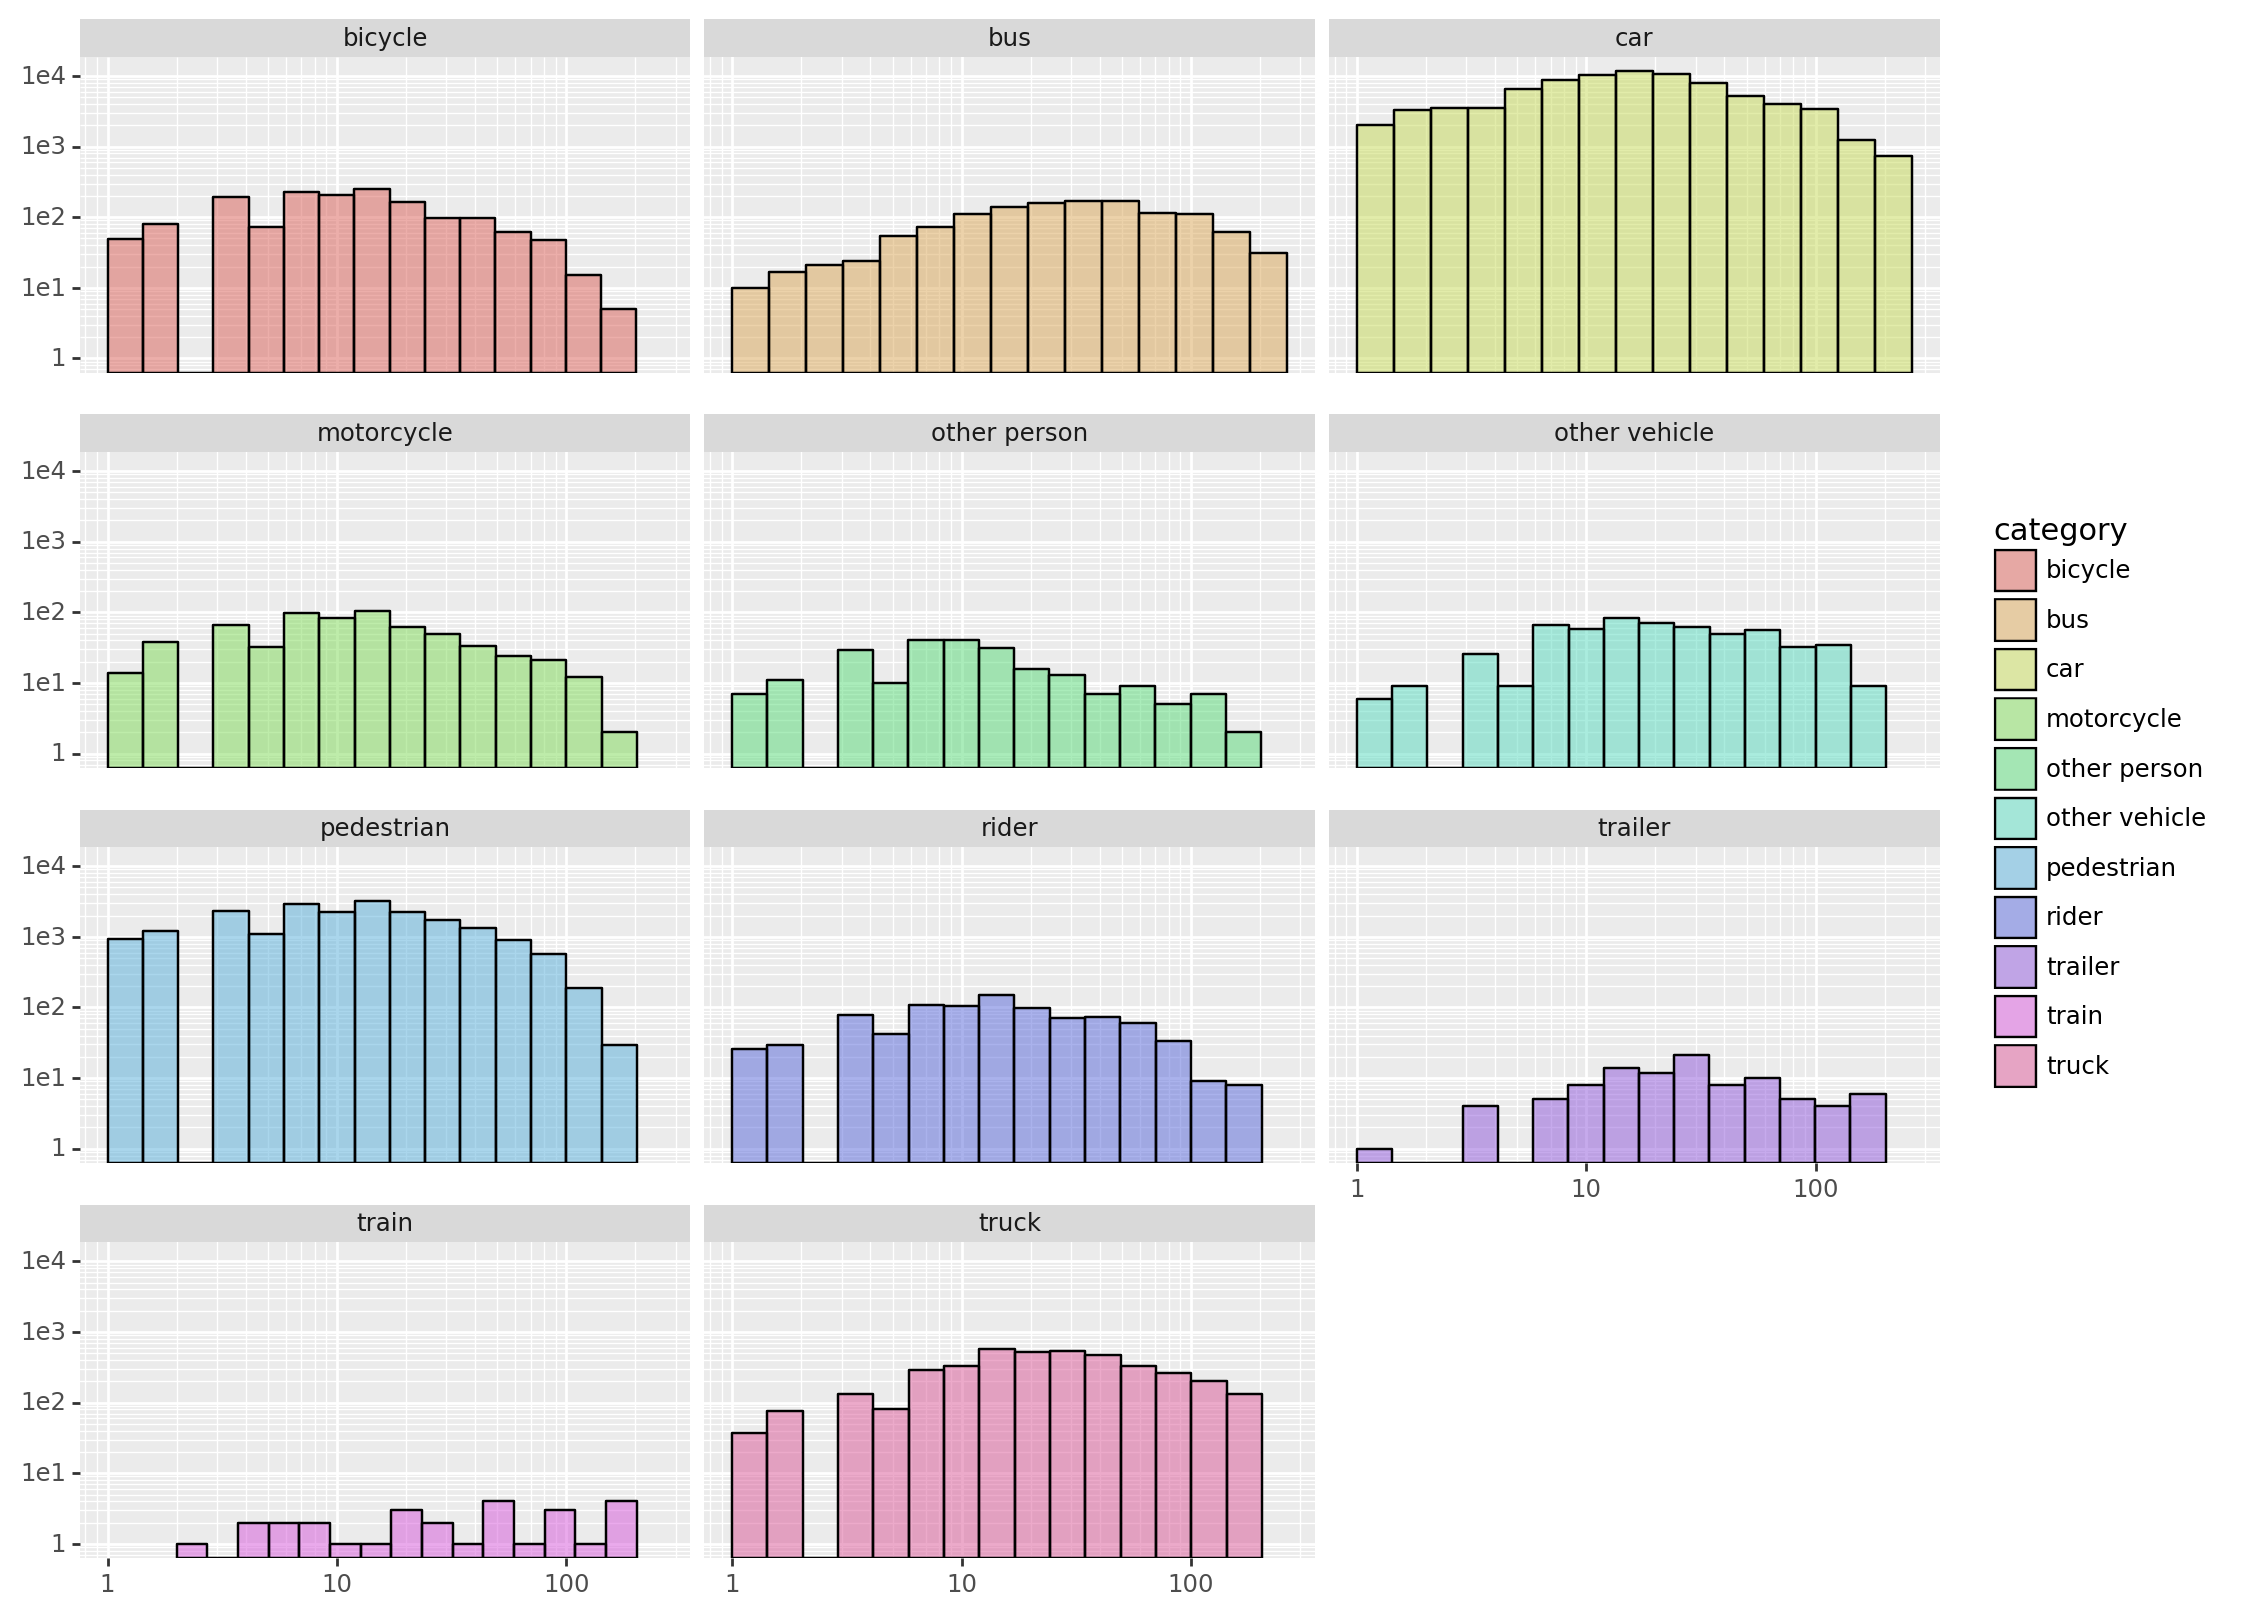

<ggplot: (-9223363280999508136)>

In [99]:
(ggplot(pdf)
         + geom_rect(aes(xmin='xstart',ymax='freq',ymin=0., xmax='xend', fill='category'), color='black', alpha=.5)
#         + geom_bar(aes())
         + scale_y_log10()
         + scale_x_log10()
         + facet_wrap(facets=['category'], ncol=3)
         + theme(figure_size=(4*3,3*3.25), 
                subplots_adjust={'hspace':.25}
                )
)

In [103]:
len(os.listdir(base)) + len(os.listdir(baseval))

1600

In [108]:
all_annot.name.value_counts().sort_index()

0000f77c-6257be58-0000001.jpg    2
0000f77c-6257be58-0000002.jpg    2
0000f77c-6257be58-0000003.jpg    2
0000f77c-6257be58-0000004.jpg    2
0000f77c-6257be58-0000005.jpg    3
                                ..
03d93dd6-990f83bb-0000198.jpg    5
03d93dd6-990f83bb-0000199.jpg    5
03d93dd6-990f83bb-0000200.jpg    5
03d93dd6-990f83bb-0000201.jpg    5
03d93dd6-990f83bb-0000202.jpg    5
Name: name, Length: 274149, dtype: int64

In [115]:
all_annot = all_annot.assign(split = pd.Categorical(all_annot.video_name).codes)

In [251]:
all_annot.to_parquet('/nvme_drive/orm/bdd_mot_labels.parquet')

/nvme_drive/vsms3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:383: FutureWarning: RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead
/nvme_drive/vsms3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:384: FutureWarning: RangeIndex._stop is deprecated and will be removed in a future version. Use RangeIndex.stop instead
/nvme_drive/vsms3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:385: FutureWarning: RangeIndex._step is deprecated and will be removed in a future version. Use RangeIndex.step instead


In [257]:
import vsms.exsample_benchmark
from vsms.exsample_dataset import *
import importlib
import vsms
importlib.reload(vsms.exsample_benchmark)
importlib.reload(vsms)
from vsms.exsample_benchmark import *

In [258]:
m = DatasetMetadata(name='bdd_mot_labels',
                boxpath='/nvme_drive/orm/bdd_mot_labels.parquet',
                track_id='id',
                frame_id='frame_idx',
                video_len=None,
                category='category',
                categories=None,
                default_chunks=('/nvme_drive/orm/bdd_mot_frames.parquet','video_name'),
                logitpath=None,
                logitsplit=None)

In [259]:
bd = BenchmarkDataset(m)

In [260]:
def getPs(ds,dsplit):
    tmp = dsplit.value_counts().sort_index()
    split_ids = tmp.index
    split_sizes = tmp.values
    okb = ds.ok_boxes.assign(split=dsplit[ds.ok_boxes.frame_id].values)
    tns = okb.groupby(['track_id', 'category','split']).agg(track_length=pd.NamedAgg('frame_id','count')).reset_index()
    tns = tns.assign(split_size=split_sizes[tns.split])
    tns = tns.assign(p=tns.track_length/tns.split_size)
    pdf = tns[['category','split','p','track_id']]
    
    mats = []
    for (k,gp) in pdf.groupby('category'):
        mat = gp.pivot(values='p',columns='split',index='track_id').fillna(0)    
        mat = mat.transpose().reindex(split_ids).fillna(0).transpose()
        assert mat.shape[1] == split_sizes.shape[0]
        mats.append((k,mat))

    return OrderedDict(mats)

In [261]:
ps = getPs(bd, bd.default_chunks)

In [324]:
import vsms.exsample_analytic
importlib.reload(vsms.exsample_analytic)
from vsms.exsample_analytic import get_target_lambdas, estimate_lambdas

In [325]:
P = ps['bicycle'].values

In [331]:
rs[0]

,lam,loss,actualN,nrandom,wns,optn,ratio,wdist,recall,category
0,1.933960,1422.705648,28.613717,290.6225624720441,"[-5.704530904360572e-10, -5.704530904360572e-1...",12.057830,24.1024,0.531309,0.020038,bicycle
1,0.339993,1274.075549,336.388311,4518.444364988211,"[1.0993685521179023e-09, 1.0993685521179023e-0...",536.670061,8.41941,0.143324,0.235566,bicycle
2,0.059771,794.112039,951.690397,27103.268716596558,"[4.408847725951691e-08, 4.408847725951691e-08,...",5316.989635,5.09748,0.064551,0.666450,bicycle
3,0.010508,329.533434,1299.429512,85220.39157007675,"[7.454945489773952e-07, 7.454945489773952e-07,...",19125.052421,4.45596,0.048263,0.909965,bicycle


In [327]:
rs = []
for (k,v) in ps.items():
    r = get_target_lambdas(v.values)
    rs.append(r.assign(category=k))

Using lambda range:  [1.93396040e+00 3.39992620e-01 5.97711213e-02 1.05078367e-02
 1.84729064e-03]


failed optw

Using lambda range:  [2.41627323e+00 4.01291358e-01 6.66459206e-02 1.10684635e-02
 1.83823529e-03]



Using lambda range:  [18.13504121  4.5585323   1.14585991  0.28803019  0.07240099]


failed optw

Using lambda range:  [1.51148515 0.28260948 0.05284082 0.0098799  0.00184729]



Using lambda range:  [1.67821782 0.30568213 0.05567905 0.01014176 0.00184729]



Using lambda range:  [1.45950495 0.27528845 0.05192427 0.00979384 0.00184729]



Using lambda range:  [1.23853698e+01 1.04000452e+00 8.73296013e-02 7.33310200e-03
 6.15763547e-04]



Using lambda range:  [1.5199005  0.28378875 0.05298772 0.00989362 0.00184729]


failed optw

Using lambda range:  [2.43128713 0.48003013 0.09477652 0.01871255 0.00369458]


failed optw

Using lambda range:  [0.96673267 0.21746254 0.0489173  0.01100375 0.00247525]


failed optw
failed optw
failed optw

Using lambda range:  [3.49280837e+00 5.30335921e-01 8.05243687e-02 1.22265411e-02
 1.85643564e-03]


failed optw



In [328]:
ratios = pd.concat(rs, ignore_index=True)

In [341]:
ratios = ratios.assign(ratio=ratios.ratio.astype('float'))

In [356]:
ratios[ratios.category == 'truck']

,lam,loss,actualN,nrandom,wns,optn,ratio,wdist,recall,category
43,3.492808,3866.566287,19.970470,37.370984394507545,"[-6.067902422058849e-10, -6.031583311053113e-1...",5.020819,7.443205,0.398047,0.005162,truck
44,0.530336,3307.517609,1238.533780,3438.2939609328764,"[2.3058743101001103e-09, 4.011448706732648e-09...",1276.646300,2.693224,0.058116,0.320117,truck
45,0.080524,1744.129583,2935.771307,20179.943586153277,"[1.5311733467136843e-08, 4.5260722715985935, 2...",10070.254488,2.003916,0.030848,0.758793,truck
46,0.012227,610.006651,3649.294566,64439.54346425072,"[1.0299200832555784e-07, 19.938662179842503, 2...",31922.455036,2.018627,0.025123,0.943214,truck


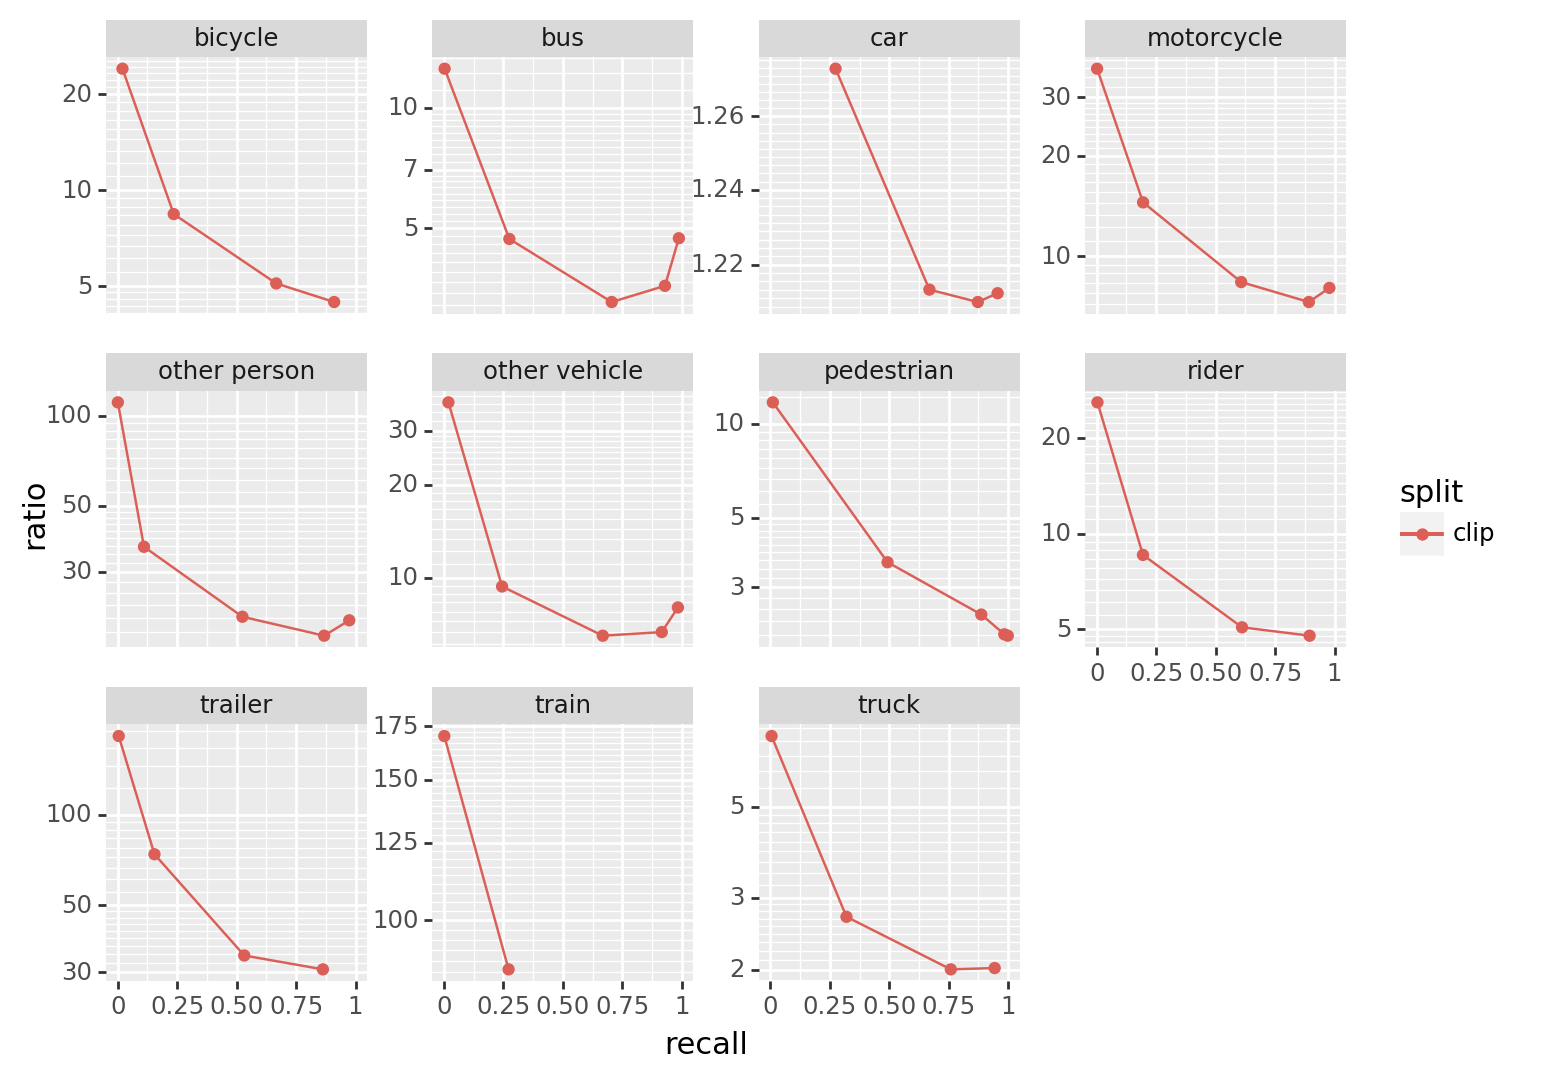

<ggplot: (8755221629732)>

In [349]:
(ggplot(ratios.assign(split='clip'))
 + geom_line(aes(x='recall',y='ratio',color='split'))
 + geom_point(aes(x='recall',y='ratio',color='split'))
 + facet_wrap(facets=['category'],scales='free_y')
 + scale_y_log10()
 + theme(subplots_adjust={'wspace': 0.25, 'hspace':.3},
        figure_size=(4*2,3*2))
)

In [1]:
ratios

NameError: name 'ratios' is not defined

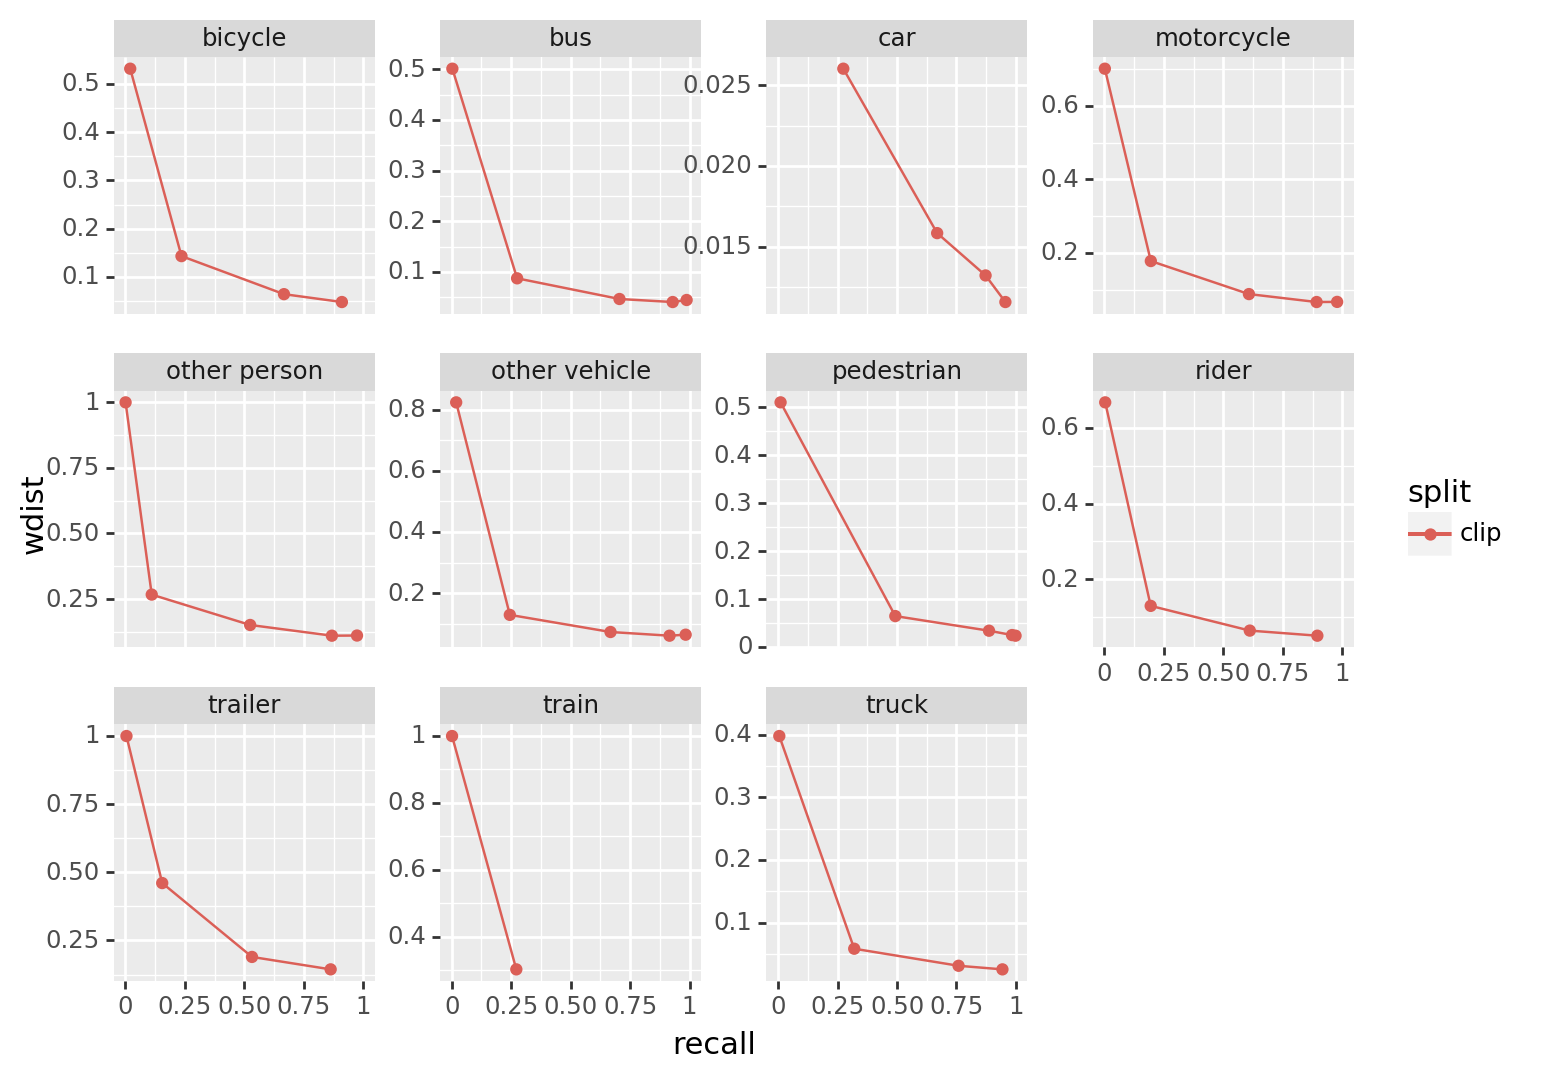

<ggplot: (8755221312688)>

In [351]:
(ggplot(ratios.assign(split='clip'))
 + geom_line(aes(x='recall',y='wdist',color='split')) 
 + geom_point(aes(x='recall',y='wdist',color='split'))
 + facet_wrap(facets=['category'],scales='free_y')
#  + scale_y_log10()
 + theme(subplots_adjust={'wspace': 0.25, 'hspace':.3},
        figure_size=(4*2,3*2))
)

In [350]:
## 1) what does this mean for the paper:
### a) gives upper bound on speed. shows common classes benefit little.

In [352]:
## can do
# 1) run benchmark and see how we actually do
# 

In [354]:
from plotnine import *
#ratios